## This Notebook serves as a walthrough to irt models & demonstrate following objective:
  1. Obtain Item parameters of a 4 PL (parameter logistic) IRT model by training an equivalent Deep Neural Network.

  2. Realise smaller models such as 1PL via 4PL model trained using hyper parameter search viz. NAS functionality

### Item Response Theory: Brief context
It is also known as psychometric theory or latent response theory. It measures the ability or latent trait of a person by looking at the responses for items or questions asked using statistical models. It assumes as ability increases, probability of correct response also increases. This relationship can be depicted from Item Characteristic Curve (ICC) which is S-shaped or sigmoid curve. It calculates parameters like discrimination, difficulty and guessability for each item and ability for every user. 

### Model specification -- keras 4PL
    `4PL model` uses Four parameters difficulty, item discrimination, item guesssability and item slip to calculate the probability of correct response given the ability of person.
. . .

If $i$ be a $question$ and $j$ be a $user$. Then, Probability $P_{ij}$ of an $j^{th}$ $user$ responding correctly to $i^{th}$ $question$, where $a_i$ is the $discrimination$ parameter, $b_i$ is difficulty, $c_j$ is guessability and $s_j$ is probability of slip for all $questions$, is given by:

\begin{equation}\
P_{ij} =  c_i+ [(1-s_i) - c_i]Sigmoid(a_i(\theta_j-b_i))
\end{equation}
Where
\begin{equation}
\text{Sigmoid}(x) =  \frac{e^{x}}{1 + e^{x}}
\end{equation}

_________________________________________________

### 1. Load 1-Parameter logistic IRT dataset with values of item difficulties levels, user abilities & response of various users on various given items.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def generate_train_test(train_data, size= 0.1):
    df_new = train_data[['question_code', 'user_id', 'correctness']]
    df_cols = df_new.columns
    xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=size)
    x_train_user = pd.get_dummies(xtrain['user_id']).values#contains the one-hot encoded user data
    x_train_questions = pd.get_dummies(xtrain['question_code']).values#contains the one-hot encoded questions

    y_train= ytrain.values
    print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
          '\nshape of y_train:',y_train.shape)
    return train_data, xtrain, y_train, x_train_user, x_train_questions


path= "../datasets/irt_4pl_dataset.csv"
df= pd.read_csv(path)


train_data, xtrain, y_train, x_train_user, x_train_questions = generate_train_test(df, size= 0.05)
df.head(3)

2021-08-05 12:17:12,406	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2021-08-05_12-17-12_258/logs.
2021-08-05 12:17:12,530	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:64240 to respond...
2021-08-05 12:17:12,663	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:30595 to respond...
2021-08-05 12:17:12,667	INFO services.py:760 -- Starting Redis shard with 20.0 GB max memory.
2021-08-05 12:17:12,706	INFO services.py:1384 -- Starting the Plasma object store with 1.0 GB memory using /dev/shm.


shape of x_train_user: (95000, 100) 
shape of x_train_questions: (95000, 100) 
shape of y_train: (95000,)


,question_code,user_id,difficulty,ability,response,correctness
0,que_99,user_99,1.0,0.559055,0.391516,0
1,que_99,user_99,1.0,0.559055,0.391516,0
2,que_99,user_99,1.0,0.559055,0.391516,1


_____________________________________

### 2. Instantiate a 4-Parameter Logistic IRT model, as primal model.

In [2]:
from mlsquare.models import fourPL

primal = fourPL()
primal

fourPL(IRT_param=None, constraint='NULL', control=[], data=None, max_guessing=1,
       na_action='NULL', start_val='NULL', type_='latent_trait')

___________________________________

### 3. Define initialization values for user & item parameters, boundary constraints or search space for hyper parameters. 
*Note:* Search space constraints are defined such that high regularization enforces 4PL model to imitates 1PL model, thus fitting the current 1PL dataset theoretically.

**4PL model as 1PL: Passing activity_regularizers l1 to hyperOpt search for layers (discrimination, guess, slip) corresponding to 1PL dataset, that is by pushing the guess_params & slip_params contribution in overall estimation to 0 and  disc_params's contribution to 1.**

In [3]:
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from hyperopt import hp

src_space= {
    "slip_params.group_lasso.l1": hp.uniform("slip_params.group_lasso.l1", 0, 10),
    "guess_params.group_lasso.l1": hp.uniform("guess_params.group_lasso.l1", 0, 10),
    "disc_params.group_lasso.l1": hp.uniform("disc_params.group_lasso.l1", 0, 10),

}
nas_params= {'search_algo_name':'hyperOpt', 'search_space':src_space, 'union':False}

params_= {'disc_params':{'kernel_params':{'stddev':0.2}},
    'guess_params':{'kernel_params':{'stddev':0.2}},
          'slip_params':{'kernel_params':{'stddev':0.2}
                        }
         }

_________________________________________

### 4. "Dope" the primal model to obtain an equivalent 4PL Deep Neural Network on 1PL data, passing initializations & search space constraints.

In [4]:
from mlsquare import dope

model_4t1 = dope(primal)
model_4t1.fit(x_user= x_train_user, x_questions= x_train_questions, y_vals= y_train, batch_size= 128, epochs=450,
        params=params_, nas_params=nas_params)


Transpiling your model to it's Deep Neural Network equivalent...
2021-08-05 12:20:05,090	ERROR worker.py:1412 -- Calling ray.init() again after it has already been called.



Intitializing fit for fourPL model. . .
Batch_size: 128; epochs: 450;
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 90.000: None | Iter 30.000: None | Iter 10.000: None
Bracket: Iter 90.000: None | Iter 30.000: None
Bracket: Iter 90.000: None
Resources requested: 0/4 CPUs, 0/1 GPUs
Memory usage on this node: 1.4/13.6 GB



2021-08-05 12:20:05,507	ERROR worker.py:1780 -- Warning: The actor WrappedFunc has size 19782331 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 90.000: None | Iter 30.000: None | Iter 10.000: None
Bracket: Iter 90.000: None | Iter 30.000: None
Bracket: Iter 90.000: None
Resources requested: 4/4 CPUs, 0/1 GPUs
Memory usage on this node: 1.5/13.6 GB
Result logdir: /root/ray_results/hyperOpt_optimization
Number of trials: 4 ({'RUNNING': 1, 'PENDING': 3})
PENDING trials:
 - train_model_2_disc_params.group_lasso.l1=6.5627,guess_params.group_lasso.l1=2.9186,slip_params.group_lasso.l1=1.3818:	PENDING
 - train_model_3_disc_params.group_lasso.l1=6.6343,guess_params.group_lasso.l1=7.145,slip_params.group_lasso.l1=5.1955:	PENDING
 - train_model_4_disc_params.group_lasso.l1=0.8419,guess_params.group_lasso.l1=9.5492,slip_params.group_lasso.l1=4.4229:	PENDING
RUNNING trials:
 - train_model_1_disc_params.group_lasso.l1=2.7829,guess_params.group_lasso.l1=3.9435,slip_params.group_lasso.l1=5.9648:	RUNNING

(pid=312) 2021-08-05 12:20:06.470238: I tensorflow/stream_executor/platform/d

2021-08-05 12:25:36,059	ERROR worker.py:1780 -- Warning: The actor WrappedFunc has size 19782331 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 90.000: None | Iter 30.000: None | Iter 10.000: None
Bracket: Iter 90.000: None | Iter 30.000: None
Bracket: Iter 90.000: None
Resources requested: 0/4 CPUs, 0/1 GPUs
Memory usage on this node: 1.7/13.6 GB
Result logdir: /root/ray_results/hyperOpt_optimization
Number of trials: 4 ({'TERMINATED': 1, 'PENDING': 3})
PENDING trials:
 - train_model_2_disc_params.group_lasso.l1=6.5627,guess_params.group_lasso.l1=2.9186,slip_params.group_lasso.l1=1.3818:	PENDING
 - train_model_3_disc_params.group_lasso.l1=6.6343,guess_params.group_lasso.l1=7.145,slip_params.group_lasso.l1=5.1955:	PENDING
 - train_model_4_disc_params.group_lasso.l1=0.8419,guess_params.group_lasso.l1=9.5492,slip_params.group_lasso.l1=4.4229:	PENDING
TERMINATED trials:
 - train_model_1_disc_params.group_lasso.l1=2.7829,guess_params.group_lasso.l1=3.9435,slip_params.group_lasso.l1=5.9648:	TERMINATED, [4 CPUs, 0 GPUs], [pid=312], 327 s, 1 iter, 0.693 acc

(pid=313) 202

2021-08-05 12:31:06,491	ERROR worker.py:1780 -- Warning: The actor WrappedFunc has size 19782331 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


(pid=313) 
(pid=313) 2900/2969 [============================>.] - ETA: 0s - loss: 0.5842 - mae: 0.3963 - accuracy: 0.6933
Result for train_model_2_disc_params.group_lasso.l1=6.5627,guess_params.group_lasso.l1=2.9186,slip_params.group_lasso.l1=1.3818:
  checkpoint: weights_tune_[(2, 'disc_params.group_lasso.l1'), (9, 'guess_params.group_lasso.l1'),
    (5, 'slip_params.group_lasso.l1')].h5
  date: 2021-08-05_12-31-06
  done: true
  experiment_id: acc4cfab0ec841ce9a8abf40a281c9f7
  hostname: d005995f49c5
  iterations_since_restore: 1
  mean_accuracy: 0.6934000253677368
  mean_error: 0.5841391086578369
  node_ip: 172.28.0.2
  pid: 313
  time_since_restore: 327.1404161453247
  time_this_iter_s: 327.1404161453247
  time_total_s: 327.1404161453247
  timestamp: 1628166666
  timesteps_since_restore: 0
  training_iteration: 1
  
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 90.00

2021-08-05 12:36:48,645	ERROR worker.py:1780 -- Warning: The actor WrappedFunc has size 19782331 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


(pid=3230) 2021-08-05 12:36:49.768151: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
(pid=3230) 2021-08-05 12:36:51,048	ERROR worker.py:1412 -- Calling ray.init() again after it has already been called.
(pid=3230) 
(pid=3230) config val 1:
(pid=3230)  key_list: ['disc_params', 'group_lasso'];
(pid=3230)  values: {'l1': 0.8418982931597918, 'l2': 0}
(pid=3230) 
(pid=3230) 
(pid=3230) 
(pid=3230) config val 2:
(pid=3230)  key_list: ['guess_params', 'group_lasso'];
(pid=3230)  values: {'l1': 9.54924129569551, 'l2': 0}
(pid=3230) 
(pid=3230) 
(pid=3230) 
(pid=3230) config val 3:
(pid=3230)  key_list: ['slip_params', 'group_lasso'];
(pid=3230)  values: {'l1': 4.4228552146004905, 'l2': 0}
(pid=3230) 
(pid=3230) 
(pid=3230) 
(pid=3230) Intitializing fit for fourPL model. . .
(pid=3230) Batch_size: 128; epochs: 450;
(pid=3230) 2021-08-05 12:36:51.897031: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Succes

**Following lists the layer names in order from model archiecture of doped model.**

Note:
* trained weights of layer 8 named `slip_param` corresponds to  slip parameter values.
* trained weights of layer 9 named `guessing_param` corresponds to guess parameter values.
* trained weights of layer 1 named `disc_param` corresponds to discrimination parameter values.
* trained weights of layer 4 named `latent_trait/ability` corresponds to user ability values.

In [5]:
for idx, lay in enumerate(model_4t1.model.layers):
    print('{} and layer name: {}'.format(idx, lay.name))

0 and layer name: questions/items
1 and layer name: disc_param
2 and layer name: user_id
3 and layer name: disc_activation
4 and layer name: latent_trait/ability
5 and layer name: difficulty_level
6 and layer name: lambda_latent_inter.
7 and layer name: alpha_param.
8 and layer name: slip_param
9 and layer name: guessing_param
10 and layer name: alpha_lambda_add
11 and layer name: slip_param_inter.
12 and layer name: Sigmoid_func
13 and layer name: slip/guess_interaction
14 and layer name: disc/guess_param_inter.
15 and layer name: guess_param_inter/add
16 and layer name: prediction_layer


### Obtain User & Item parameters from trained 4PL IRT model
**User parameters (per user):** Ability values.

**Item parameters (per item):** Item difficulty, Item Discrimination, Item guessability, Item Slip



In [6]:
import matplotlib.pyplot as plt
def get_keras_parameters(model, xtrain):# model is a dope object
    ability = model.coefficients()['latent_trait/ability']
    ability = [x[0] for x in ability]

    diff= model.coefficients()['difficulty_level']
    diff = [x[0] for x in diff]
    
    disc= model.coefficients()['disc_param']
    disc = [x[0] for x in disc]
    
    guess= model.coefficients()['guessing_param']
    guess = [x[0] for x in guess]
    
    slip= model.coefficients()['slip_param']
    slip = [x[0] for x in slip]

    question_code = pd.get_dummies(xtrain['question_code']).columns
    df_quest_related_params = pd.DataFrame({'slip_keras':slip, 'guessing_keras':guess, 'discrimination_keras': disc,'difficulty_keras': diff, 'question_code':question_code})

    user_id = pd.get_dummies(xtrain['user_id']).columns
    df_ability = pd.DataFrame({'user_id':user_id, 'ability_keras':ability})
    return df_quest_related_params, df_ability

def scatter_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.5
    max_x = max(list(x)+list(y)) + 0.5
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    ax.scatter(x, y, c="red")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
def hexbin_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.1
    max_x = max(list(x)+list(y)) + 0.1
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    hbin= ax.hexbin(x, y, gridsize=25, mincnt=2)
    cb = fig.colorbar(hbin, ax=ax)
    cb.set_label('occurence_density')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [7]:
question_code = pd.get_dummies(xtrain['question_code']).columns
user_id = pd.get_dummies(xtrain['user_id']).columns

quest_related_params_df, ability_df = get_keras_parameters(model_4t1, xtrain)

true_difficulty = {_.question_code: _.difficulty for _ in train_data.itertuples()}
quest_related_params_df['difficulty_true'] = quest_related_params_df['question_code'].apply(lambda x: true_difficulty.get(x))

quest_related_params_df['discrimination_true']= 1#Disc 1; Since Input data was for 1 PL model

quest_related_params_df['guessing_true'] = 0 #Guess 0; Since Input data was for 1 PL model

quest_related_params_df['slip_true']=0 #Slip 0; Since Input data was for 1 PL model

quest_related_params_df.head(3)

,slip_keras,guessing_keras,discrimination_keras,difficulty_keras,question_code,difficulty_true,discrimination_true,guessing_true,slip_true
0,0.000089,0.000052,0.999977,-1.041043,que_0,-1.000000,1,0,0
1,0.000088,0.000049,0.999977,-1.027209,que_1,-0.979798,1,0,0
2,0.000079,0.000043,1.000103,-0.749467,que_10,-0.797980,1,0,0


In [8]:
true_ability = {_.user_id: _.ability for _ in train_data.itertuples()}
ability_df['ability_true'] = ability_df['user_id'].apply(lambda x: true_ability.get(x))
ability_df.head(3)

,user_id,ability_keras,ability_true
0,user_0,-0.484500,-0.501354
1,user_1,0.336772,0.330120
2,user_10,2.554405,2.763429


_________________________________________
### Plots: Observed parameters vs. True parameters correlation

#### 1. Observed Slip vs. True Slip

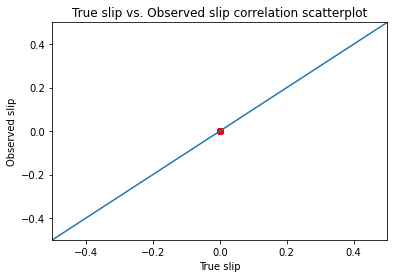

In [17]:
scatter_plot(quest_related_params_df['slip_true'], quest_related_params_df['slip_keras'], "True slip", "Observed slip")

#### 2. Observed Guess vs. True Guess

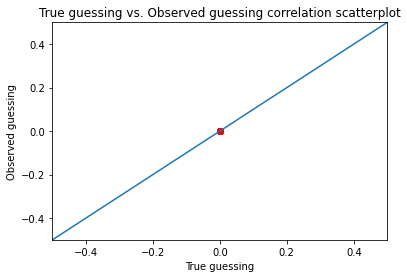

In [18]:
scatter_plot(quest_related_params_df['guessing_true'], quest_related_params_df['guessing_keras'], "True guessing", "Observed guessing")

#### 3. Observed Discrimination vs. True Discrimination

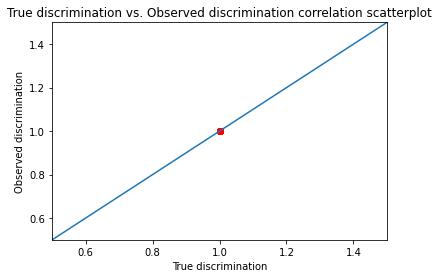

In [19]:
scatter_plot(quest_related_params_df['discrimination_true'], quest_related_params_df["discrimination_keras"], "True discrimination", "Observed discrimination")


#### 4. Observed Difficulty vs. True Difficulty

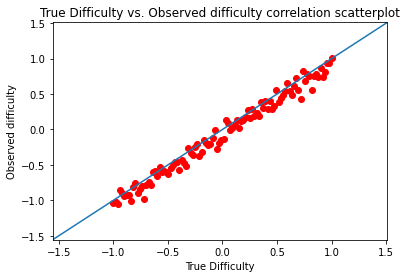

In [20]:
scatter_plot(quest_related_params_df['difficulty_true'], quest_related_params_df['difficulty_keras'], "True Difficulty", "Observed difficulty")


#### 5. Observed Abilities vs. True Abilities

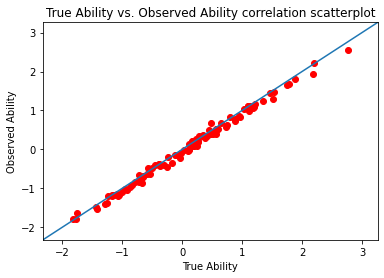

In [21]:
scatter_plot(ability_df['ability_true'], ability_df['ability_keras'], "True Ability", "Observed Ability")


#### 6. Observed Response vs. True Response

In [14]:
import math
def fourPL_func(ability, diff, disc, guess, slip):
    res= guess + ((1-slip) + guess)*(1 / (1 + math.exp(-disc*(ability-diff))))
    return res
def get_true_values(quest_related_params_df, ability_df, train_data):
    difficulty_keras_map = {_.question_code: _.difficulty_keras for _ in quest_related_params_df.itertuples()}
    ability_keras_map = {_.user_id: _.ability_keras for _ in ability_df.itertuples()}
    guessing_keras_map = {_.question_code: _.guessing_keras for _ in quest_related_params_df.itertuples()}
    slip_keras_map = {_.question_code: _.slip_keras for _ in quest_related_params_df.itertuples()}
    discrimination_keras_map = {_.question_code: _.discrimination_keras for _ in quest_related_params_df.itertuples()}

    train_data = train_data.drop_duplicates(['question_code', 'user_id'])
    train_data['difficulty_keras'] = train_data['question_code'].apply(lambda x: difficulty_keras_map.get(x))
    train_data['ability_keras'] = train_data['user_id'].apply(lambda x: ability_keras_map.get(x))
    train_data['guessing_keras'] = train_data['question_code'].apply(lambda x: guessing_keras_map.get(x))
    train_data['slip_keras']= train_data['question_code'].apply(lambda x: slip_keras_map.get(x))
    train_data['discrimination_keras'] = train_data['question_code'].apply(lambda x: discrimination_keras_map.get(x))
    train_data['response_keras'] = train_data.apply(lambda x: fourPL_func(x['ability_keras'], x['difficulty_keras'], x['discrimination_keras'], x['guessing_keras'], x['slip_keras']), axis=1)
    return train_data


train_data = get_true_values(quest_related_params_df, ability_df, train_data)
train_data.head(5)


,question_code,user_id,difficulty,ability,response,correctness,difficulty_keras,ability_keras,guessing_keras,slip_keras,discrimination_keras,response_keras
0,que_99,user_99,1.0,0.559055,0.391516,0,1.011985,0.401654,0.000047,0.000125,1.000112,0.351987
10,que_99,user_98,1.0,0.164593,0.302503,0,1.011985,0.181314,0.000047,0.000125,1.000112,0.303506
20,que_99,user_97,1.0,0.566402,0.393268,1,1.011985,0.517328,0.000047,0.000125,1.000112,0.378801
30,que_99,user_96,1.0,1.186521,0.546496,0,1.011985,1.059723,0.000047,0.000125,1.000112,0.511940
40,que_99,user_95,1.0,-0.039525,0.261242,0,1.011985,-0.229570,0.000047,0.000125,1.000112,0.224170


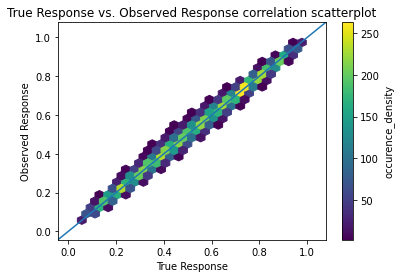

In [22]:

hexbin_plot(train_data['response'], train_data['response_keras'], "True Response", "Observed Response")


__________________________________